# 

In [1]:
# !pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

```python 
    def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    This function rescale the image's pixel intensity range. 
    e.g. original  
    [[ 34,  89, 200],
    [123, 178, 255],
    [ 12,  45, 100]]
    after rescaling : 
    [[0.133, 0.349, 0.784],
    [0.482, 0.698, 1.000],
    [0.047, 0.176, 0.392]]
```
why use it for the first step :
1. Smoother gradients: Using values ​​of [0, 1] helps prevent exploding or vanishing gradients, thus improving the training stability of the model.
2. Faster convergence: When the input data range is smaller, the neural network can converge faster, that is, find the optimal solution faster, and the training efficiency is higher.

In [4]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

Shape: torch.Size([3, 223, 320]), Dtype: torch.float32
Shape: torch.Size([3, 347, 500]), Dtype: torch.float32


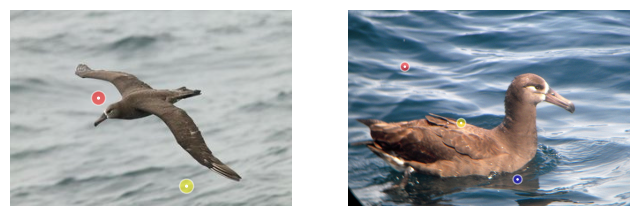

In [5]:
# This is the test code for above two functions : draw_correspondences and imsc
# It should display two images with points marked on them.
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.transforms.functional import to_tensor  # Import the correct function
import numpy as np

image1 = Image.open(r"C:\Users\user\Desktop\deep_learning\DL-FP\02456_Deep_Learning_Project\data\CUB_200_2011\images\001.Black_footed_Albatross\Black_Footed_Albatross_0001_796111.jpg")
image2 = Image.open(r"C:\Users\user\Desktop\deep_learning\DL-FP\02456_Deep_Learning_Project\data\CUB_200_2011\images\001.Black_footed_Albatross\Black_Footed_Albatross_0002_55.jpg")

# Convert to tensor
image1_tensor = to_tensor(image1).float()
image2_tensor = to_tensor(image2).float()

print(f"Shape: {image1_tensor.shape}, Dtype: {image1_tensor.dtype}")
print(f"Shape: {image2_tensor.shape}, Dtype: {image2_tensor.dtype}")

points1 = [(100, 100), (200, 200), (300, 300)]
points2 = [(100, 100), (200, 200), (300, 300)]

fig = draw_correspondences(points1, points2, image1_tensor, image2_tensor)

plt.show()



In [6]:
#@title create dataset


from transformers import AutoProcessor


# CLIP Model for image, pre-processing
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]


class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


variable x: tensor([[[ 0.8792,  0.7771,  0.8355,  ..., -0.0842, -0.0842,  0.0763],
         [ 0.8938,  0.8063,  0.8501,  ..., -0.1718, -0.0842, -0.0405],
         [ 0.7771,  0.8209,  0.9376,  ..., -0.2302, -0.0988, -0.2010],
         ...,
         [ 0.2515,  0.3829,  0.2223,  ..., -0.4638, -0.2886, -0.1572],
         [ 0.2661,  0.3245,  0.3537,  ..., -0.4784, -0.4930, -0.5806],
         [ 0.2515,  0.3537,  0.2953,  ..., -0.5952, -0.5222, -0.4638]],

        [[ 2.0149,  2.0299,  2.0449,  ...,  0.4691,  0.6491,  0.7242],
         [ 2.0299,  2.0299,  2.0149,  ...,  0.4390,  0.5291,  0.6942],
         [ 2.0449,  2.0449,  2.0149,  ...,  0.4390,  0.4841,  0.5441],
         ...,
         [ 0.7392,  0.6491,  0.6191,  ...,  0.4240,  0.5891,  0.8442],
         [ 0.7392,  0.7692,  0.6792,  ...,  0.3490,  0.3340,  0.4691],
         [ 0.7692,  0.7542,  0.7692,  ...,  0.3340,  0.3490,  0.3490]],

        [[ 0.8661,  0.9514,  0.9088,  ..., -0.2146, -0.0582,  0.0982],
         [ 0.8377,  0.8945,  0.93

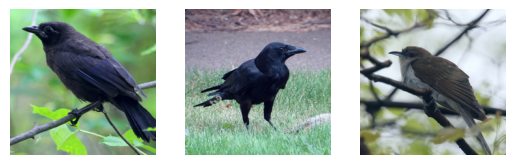

In [7]:
#@title dataset and dataloader and load samples

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/' # You need to change this.
base_path = '../data/CUB_200_2011/' # You need to change this.

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

random.seed(30)
inputs, labels = [], []
data_indices = []
#data_indices = random.sample(range(train_dataset.__len__()), 10)
# Here is where we pick the images to analyse. It is smart to pick one image from the same class and one from a different class.
# That generally gives more interesting results. The data is ordered, so class 1 starts from indices (0-30), class 2 from (30-60)
# and so on.

data_indices.append(856)
data_indices.append(858)
data_indices.append(924)


for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)
  print(f"variable x: {x}")
  print(f"variable y: {y}")

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(131)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()


In [8]:
#@title load model

from transformers import CLIPVisionModel, CLIPTextModel

# You can use the CLIPTextModel to process the text data once you get that far.
# see https://huggingface.co/docs/transformers/model_doc/clip#transformers.TFCLIPTextModel
# for more information.

model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')

text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')


inpus: [tensor([[[ 0.8792,  0.7771,  0.8355,  ..., -0.0842, -0.0842,  0.0763],
         [ 0.8938,  0.8063,  0.8501,  ..., -0.1718, -0.0842, -0.0405],
         [ 0.7771,  0.8209,  0.9376,  ..., -0.2302, -0.0988, -0.2010],
         ...,
         [ 0.2515,  0.3829,  0.2223,  ..., -0.4638, -0.2886, -0.1572],
         [ 0.2661,  0.3245,  0.3537,  ..., -0.4784, -0.4930, -0.5806],
         [ 0.2515,  0.3537,  0.2953,  ..., -0.5952, -0.5222, -0.4638]],

        [[ 2.0149,  2.0299,  2.0449,  ...,  0.4691,  0.6491,  0.7242],
         [ 2.0299,  2.0299,  2.0149,  ...,  0.4390,  0.5291,  0.6942],
         [ 2.0449,  2.0449,  2.0149,  ...,  0.4390,  0.4841,  0.5441],
         ...,
         [ 0.7392,  0.6491,  0.6191,  ...,  0.4240,  0.5891,  0.8442],
         [ 0.7392,  0.7692,  0.6792,  ...,  0.3490,  0.3340,  0.4691],
         [ 0.7692,  0.7542,  0.7692,  ...,  0.3340,  0.3490,  0.3490]],

        [[ 0.8661,  0.9514,  0.9088,  ..., -0.2146, -0.0582,  0.0982],
         [ 0.8377,  0.8945,  0.9372, 

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


img shape: torch.Size([224, 224, 3])
outputs: BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.6695,  0.8742, -0.3708,  ..., -0.3013, -0.3034, -0.4385],
         [ 0.9187,  0.1436,  1.2544,  ..., -0.0277,  0.0440,  0.0793],
         [ 1.1573,  0.0224,  1.3847,  ...,  0.2286,  0.9520, -0.4368],
         ...,
         [ 0.5455,  0.7231,  1.0579,  ...,  0.5971,  0.4840, -0.1228],
         [ 1.3511, -0.1683,  1.2807,  ..., -0.1241,  0.5094,  0.0355],
         [ 1.3220,  0.3806,  0.8457,  ..., -0.3910,  0.2945,  0.0284]]],
       device='cuda:0', grad_fn=<AddBackward0>), pooler_output=tensor([[ 1.3386,  2.0583, -0.7679,  ..., -0.2313, -0.5806, -0.9423]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)
cropped_img shape: torch.Size([224, 224, 3])
img shape: torch.Size([224, 224, 3])
outputs: BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.6695,  0.8742, -0.3708,  ..., -0.3013, -0.3034, -0.4385],
         [ 0.9187,  0.1436, 

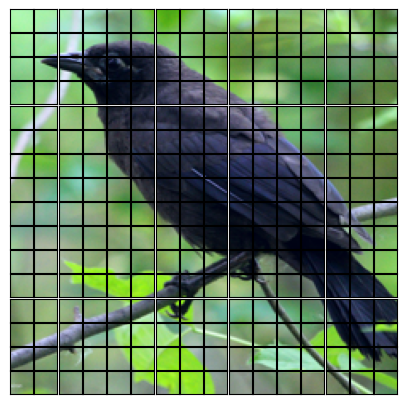

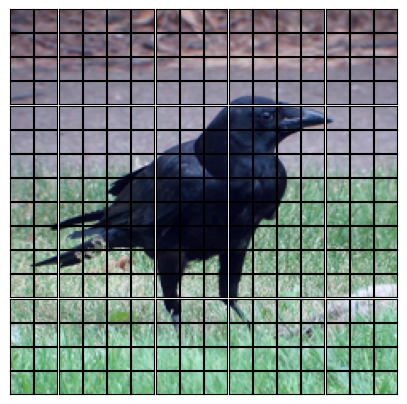

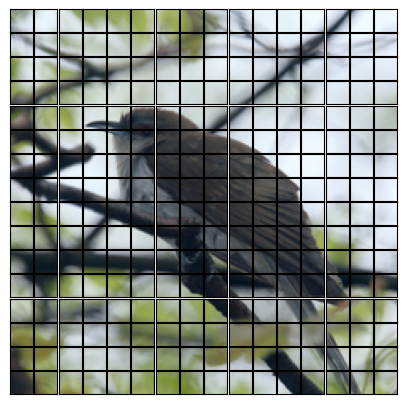

In [9]:
#@title plot patches

print(f"inpus: {inputs}")
for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    # original permute(0,1,2) -> (C,H,W)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape
    # new shape (H, W, C)
    print(f"img shape: {img.shape}")

    # create a random tensor with the same shape as the input image, batch size 1
    dummy_input = torch.zeros(1, C, H, W, device='cuda')

    outputs = model(dummy_input)
    print(f"outputs: {outputs}")

    # 256 patches, 1024 features
    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    # patch_width = 14
    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width
    # n_rows = 16, n_cols = 16

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]
    print(f"cropped_img shape: {cropped_img.shape}")
    

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    # create pathes 
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)



C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text embeddings shape: torch.Size([15, 512])
Input shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 256, 1024])
Input shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 256, 1024])
Input shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 256, 1024])
Patch embedding shape after squeeze: torch.Size([256, 1024])
Number of patches (n_patches): 256
Embedding dimension: 1024
Position embedding shape: torch.Size([256, 1024])
Patch positions: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,

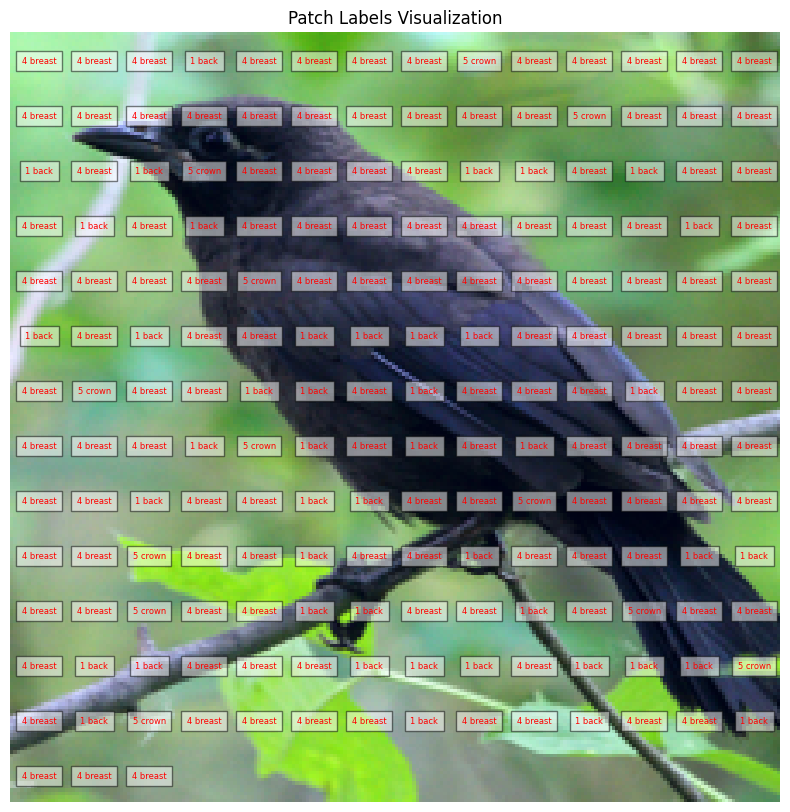

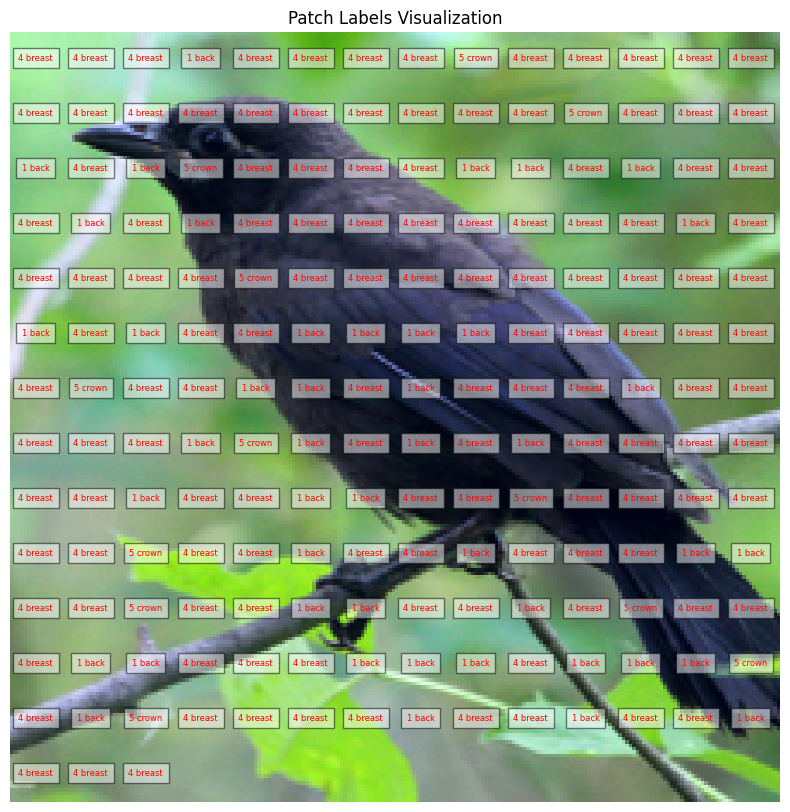

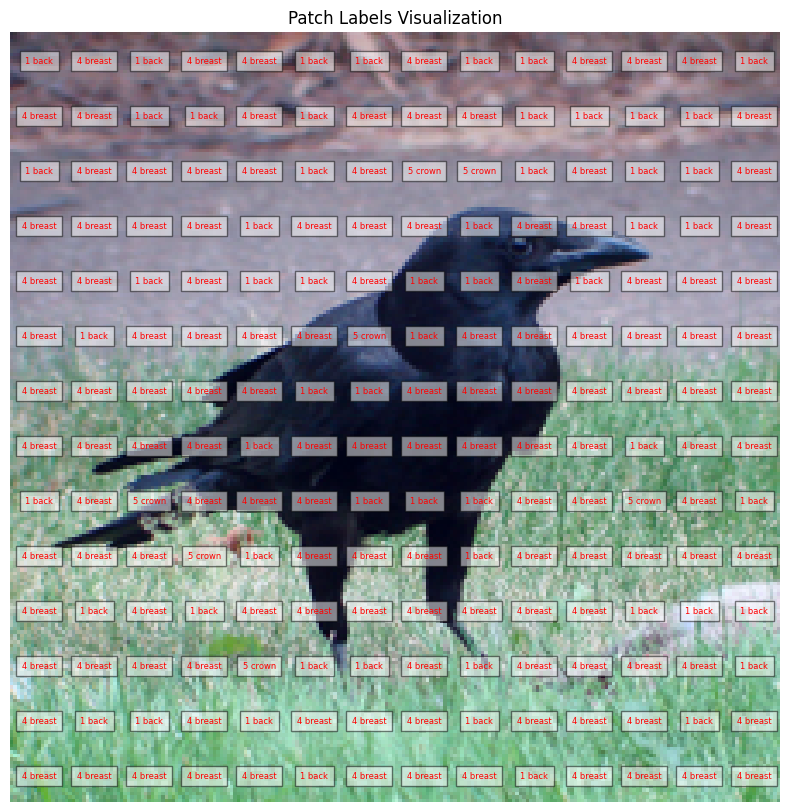

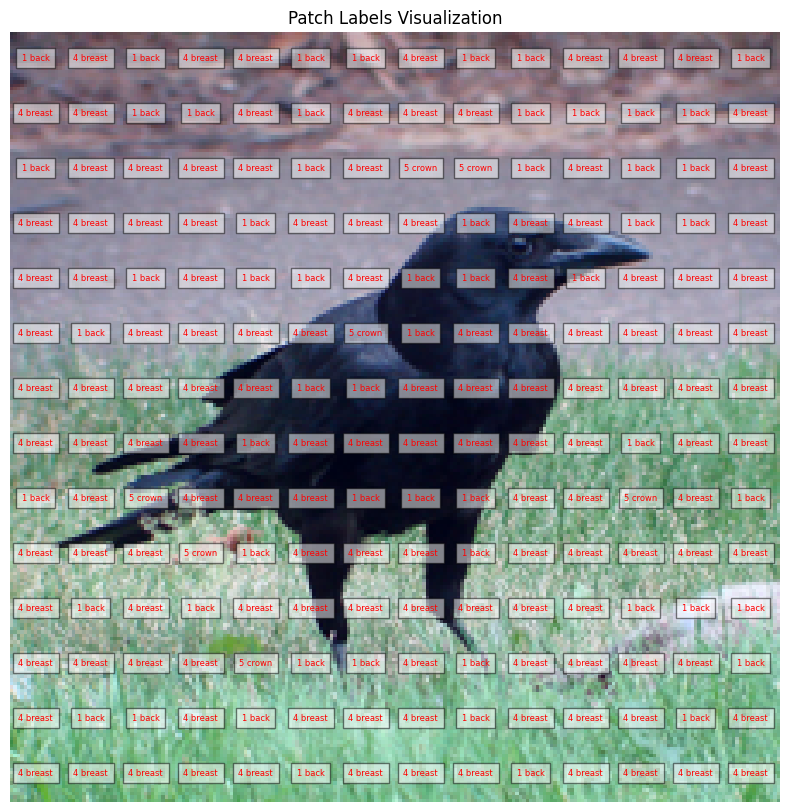

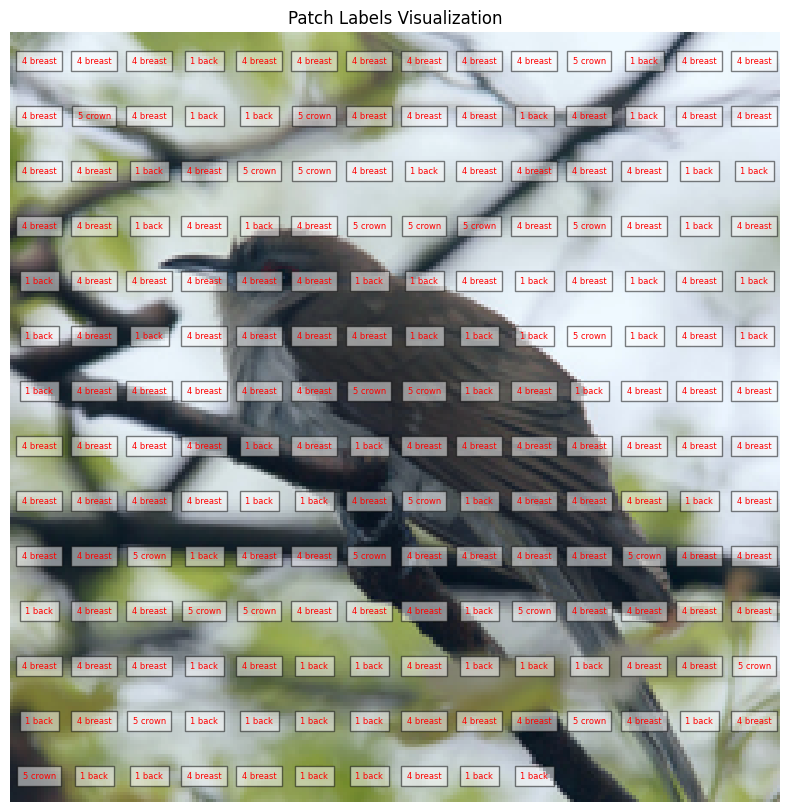

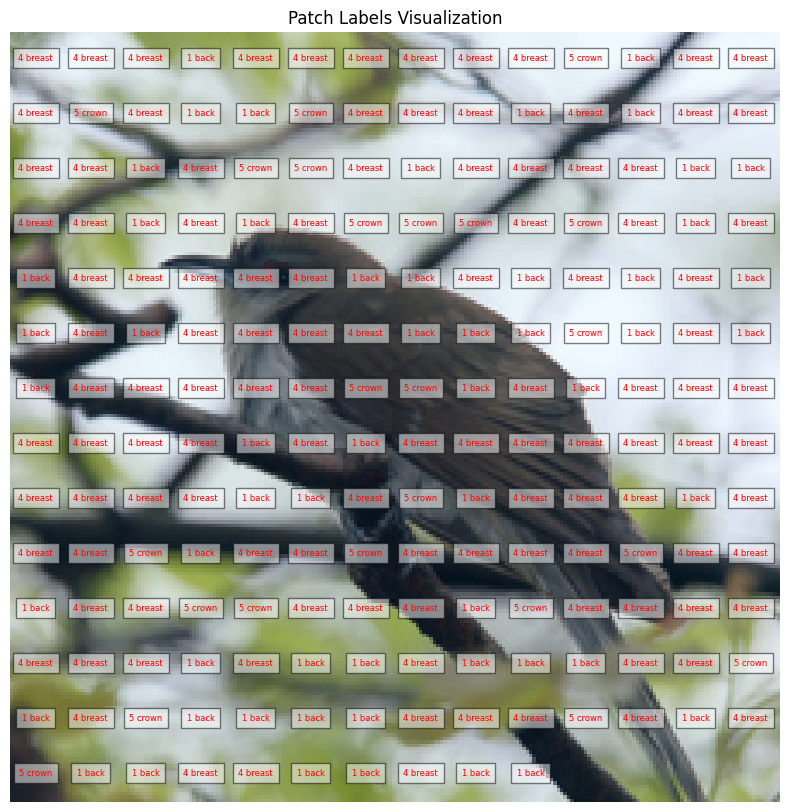

In [13]:
import torch
import numpy as np
from transformers import AutoTokenizer, CLIPTextModel
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

# Initialize device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define projection layer
projection_layer = torch.nn.Sequential(
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 512)
).to(device)

# Load CLIP text model and tokenizer
new_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Load parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]

# Generate text embeddings
text_inputs = tokenizer(parts, padding=True, return_tensors="pt")
new_outputs = new_model(**text_inputs)
new_pooled_output = new_outputs.pooler_output.to(device)
print(f"Text embeddings shape: {new_pooled_output.shape}")

# Placeholder for patch embeddings
embedings = []

# Generate patch embeddings for images
with torch.no_grad():
    for counter, input_i in enumerate(inputs):  # Assuming inputs contains preprocessed image tensors
        input_i = input_i.to(device).unsqueeze(0)
        print(f"Input shape: {input_i.shape}")

        # Ensure input size is fixed at 224x224
        input_i = torch.nn.functional.interpolate(
            input_i, size=(224, 224), mode="bilinear", align_corners=False
        )

        # Extract features from multiple layers
        outputs = model(input_i, output_attentions=False, output_hidden_states=True)
        multi_layer_embeddings = outputs.hidden_states[-4:]  # Extract last 4 layers

        # Average features across layers
        patch_embedding = torch.mean(
            torch.stack([layer[:, 1:, :] for layer in multi_layer_embeddings], dim=0), dim=0
        )
        embedings.append(patch_embedding.cpu())
        print(f"Patch embedding shape: {patch_embedding.shape}")

# Process each image's patch embeddings
matched_labels = []
for img_idx, patch_embedding in enumerate(embedings):
    patch_embedding = patch_embedding.to(device)  # Convert to tensor on GPU
    
    # 确保 patch_embedding 是二维形状
    patch_embedding = patch_embedding.squeeze(0)  # 将 (1, n_patches, embedding_dim) 转为 (n_patches, embedding_dim)
    print(f"Patch embedding shape after squeeze: {patch_embedding.shape}")
    
    # 确保 n_patches 和 embedding_dim 与 patch_embedding 的形状匹配

    n_patches = patch_embedding.shape[0]  # Number of patches
    embedding_dim = patch_embedding.shape[1]  # Embedding dimension
    
    print(f"Number of patches (n_patches): {n_patches}")
    print(f"Embedding dimension: {embedding_dim}")
    
    # 定义 position_embeddings
    position_embeddings = torch.nn.Embedding(n_patches, embedding_dim).to(device)
    patch_positions = torch.arange(n_patches, device=device)
    print(f"Position embedding shape: {position_embeddings.weight.shape}")
    print(f"Patch positions: {patch_positions}")
    
    # 添加位置嵌入，确保形状匹配
    patch_embedding = patch_embedding + position_embeddings(patch_positions)  # 形状保持为 (n_patches, embedding_dim)
    print(f"Patch embedding shape after adding position embeddings: {patch_embedding.shape}")

    # Project patch embeddings to 512 dimensions
    projected_patch_embedding = projection_layer(patch_embedding)

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(
        projected_patch_embedding.unsqueeze(1),
        new_pooled_output.unsqueeze(0)
    )

    # Threshold filtering
    threshold = 0.4
    valid_similarity = similarity_matrix > threshold
    similarity_matrix = similarity_matrix * valid_similarity

    # Find the best matching part for each patch
    best_match_indices = similarity_matrix.argmax(dim=1)
    valid_indices = [idx for idx in best_match_indices.cpu().numpy() if idx < len(parts)]
    matched_labels.append([parts[idx] for idx in valid_indices])

# Visualization function (remains unchanged)
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def visualize_patches_with_labels(image, matched_labels, patch_size=16, stride=16):
    """
    Visualize the patches of the image with their corresponding labels.
    
    Args:
    - image (torch.Tensor): Input image tensor of shape (C, H, W).
    - matched_labels (list): List of labels for each patch.
    - patch_size (int): Size of each patch (default: 16).
    - stride (int): Stride used for extracting patches (default: 16).
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) for visualization
    image = normalize_image(image)  # Normalize pixel values to [0, 1]
    H, W, _ = image.shape
    n_rows = (H - patch_size) // stride + 1
    n_cols = (W - patch_size) // stride + 1

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")

    # Overlay labels on each patch
    for i in range(n_rows):
        for j in range(n_cols):
            patch_idx = i * n_cols + j
            if patch_idx < len(matched_labels):
                label = matched_labels[patch_idx]
                y = i * stride + patch_size // 2
                x = j * stride + patch_size // 2
                plt.text(x, y, label, color="red", fontsize=6, ha="center", va="center", bbox=dict(facecolor="white", alpha=0.5))
    
    plt.title("Patch Labels Visualization")
    plt.show()
# Visualize results
for img_idx, (img, labels) in enumerate(zip(inputs, matched_labels)):
    visualize_patches_with_labels(img, labels, patch_size=16, stride=16)
    visualize_patches_with_labels(img, labels, patch_size=model.config.patch_size)

Text embeddings shape: torch.Size([15, 512])
Input shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 256, 1024])
Input shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 256, 1024])
Input shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 256, 1024])
Patch embedding shape after squeeze: torch.Size([256, 1024])
Number of patches (n_patches): 256
Embedding dimension: 1024
Position embedding shape: torch.Size([256, 1024])
Patch positions: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,

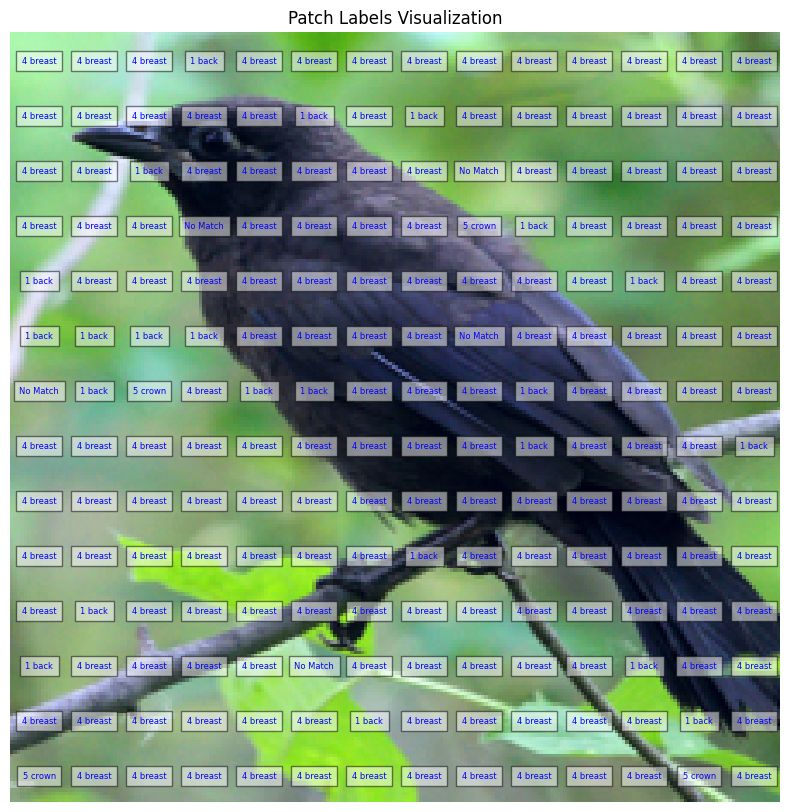

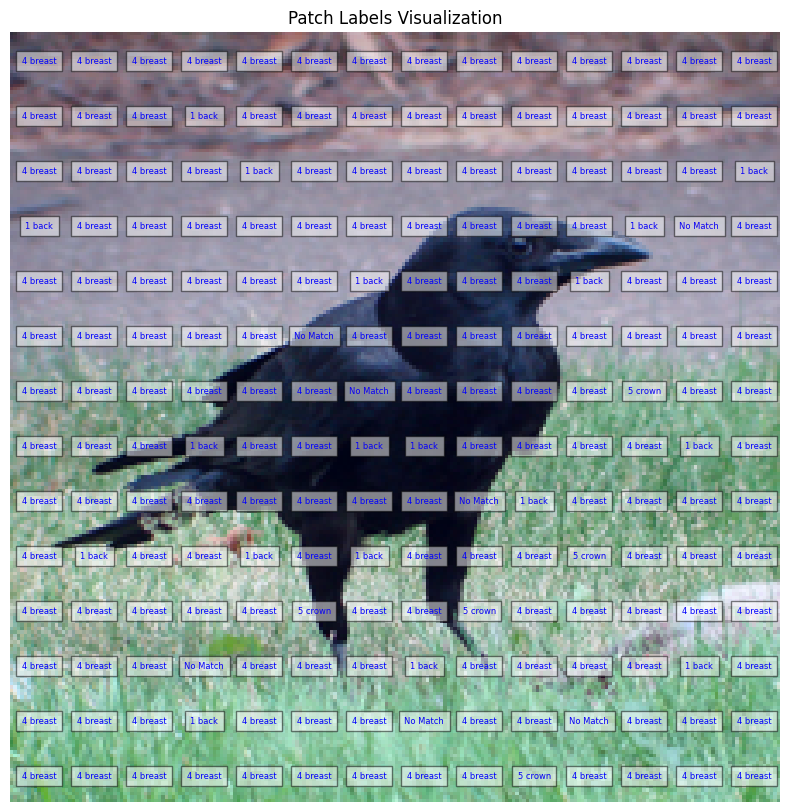

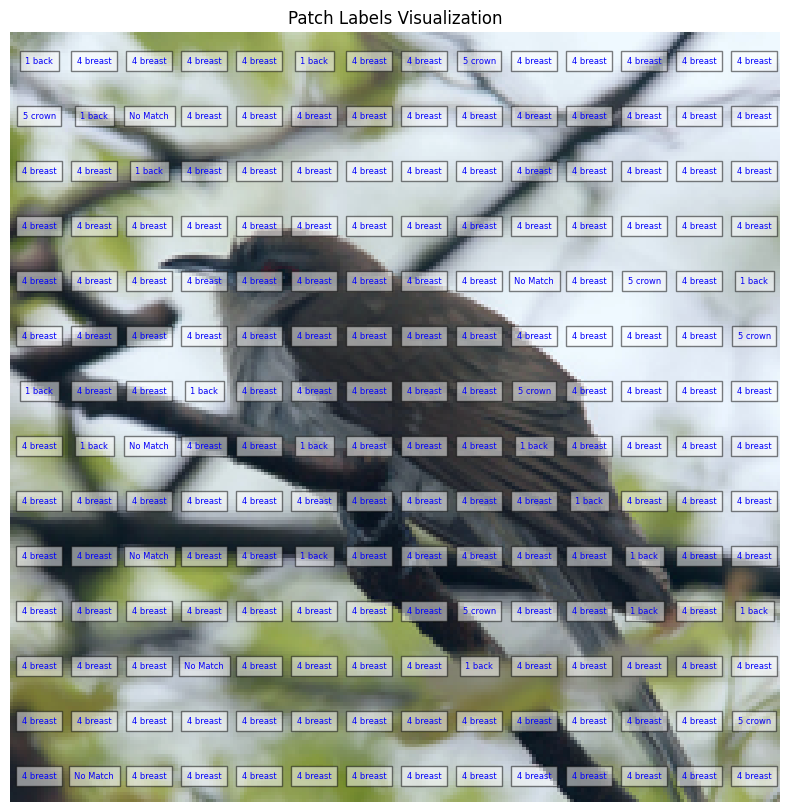

In [40]:
import torch
import numpy as np
from transformers import AutoTokenizer, CLIPTextModel
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

# Initialize device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define projection layer
projection_layer = torch.nn.Sequential(
    torch.nn.Linear(1024, 512),
    torch.nn.GELU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512)  # 添加残差
).to(device)

# Load CLIP text model and tokenizer
new_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Load parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r') as f:
    parts = [line.strip() for line in f.readlines()]

# Generate text embeddings
text_inputs = tokenizer(parts, padding=True, return_tensors="pt")
new_outputs = new_model(**text_inputs)
new_pooled_output = new_outputs.pooler_output.to(device)
print(f"Text embeddings shape: {new_pooled_output.shape}")

# Placeholder for patch embeddings
embedings = []

# Generate patch embeddings for images
with torch.no_grad():
    for counter, input_i in enumerate(inputs):  # Assuming inputs contains preprocessed image tensors
        input_i = input_i.to(device).unsqueeze(0)
        print(f"Input shape: {input_i.shape}")

        # Ensure input size is fixed at 224x224
        input_i = torch.nn.functional.interpolate(
            input_i, size=(224, 224), mode="bilinear", align_corners=False
        )

        # Extract features from multiple layers
        outputs = model(input_i, output_attentions=False, output_hidden_states=True)
        multi_layer_embeddings = outputs.hidden_states[-4:]  # Extract last 4 layers

        # Average features across layers
        patch_embedding = torch.mean(
            torch.stack([layer[:, 1:, :] for layer in multi_layer_embeddings], dim=0), dim=0
        )
        embedings.append(patch_embedding.cpu())
        print(f"Patch embedding shape: {patch_embedding.shape}")

# Process each image's patch embeddings
matched_labels = []
confidence_scores_list = []  # 保存所有图片的 confidence_scores
for img_idx, patch_embedding in enumerate(embedings):
    patch_embedding = patch_embedding.to(device)  # Convert to tensor on GPU
    
    # 确保 patch_embedding 是二维形状
    patch_embedding = patch_embedding.squeeze(0)  # 将 (1, n_patches, embedding_dim) 转为 (n_patches, embedding_dim)
    print(f"Patch embedding shape after squeeze: {patch_embedding.shape}")
    
    # 确保 n_patches 和 embedding_dim 与 patch_embedding 的形状匹配
    n_patches = patch_embedding.shape[0]  # Number of patches
    embedding_dim = patch_embedding.shape[1]  # Embedding dimension
    print(f"Number of patches (n_patches): {n_patches}")
    print(f"Embedding dimension: {embedding_dim}")
    
    #定义 position_embeddings
    position_embeddings = torch.nn.Embedding(n_patches, embedding_dim).to(device)
    patch_positions = torch.arange(n_patches, device=device)
    print(f"Position embedding shape: {position_embeddings.weight.shape}")
    print(f"Patch positions: {patch_positions}")
    
    # 添加位置嵌入，确保形状匹配
    patch_embedding = patch_embedding + position_embeddings(patch_positions)  # 形状保持为 (n_patches, embedding_dim)
    print(f"Patch embedding shape after adding position embeddings: {patch_embedding.shape}")

    # Project patch embeddings to 512 dimensions
    projected_patch_embedding = projection_layer(patch_embedding)

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(
        projected_patch_embedding.unsqueeze(1),
        new_pooled_output.unsqueeze(0)
    )

    # Threshold filtering
    threshold = torch.quantile(similarity_matrix, 0.8).item()
    valid_similarity = similarity_matrix > threshold
    similarity_matrix = similarity_matrix * valid_similarity

    # Find the best matching part for each patch
    best_match_indices = similarity_matrix.argmax(dim=1)
    matched_labels_img = [
        parts[idx] if idx < len(parts) else "No Match" for idx in best_match_indices.cpu().numpy()
    ]
    
    # Add "No Match" if the index does not pass the threshold
    for i in range(n_patches):
        if not valid_similarity[i].any():  # 如果该补丁没有有效的匹配
            matched_labels_img[i] = "No Match"

    # 保存当前图像的 matched_labels 和 confidence_scores
    matched_labels.append(matched_labels_img)
    confidence_scores_list.append(similarity_matrix.max(dim=1)[0].detach().cpu().numpy())

# Visualization function
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def visualize_patches_with_labels(image, matched_labels, patch_size=16, stride=16, confidence_scores=None):
    """
    Visualize the patches of the image with their corresponding labels.

    Args:
    - image (torch.Tensor): Input image tensor of shape (C, H, W).
    - matched_labels (list): List of labels for each patch.
    - patch_size (int): Size of each patch (default: 16).
    - stride (int): Stride used for extracting patches (default: 16).
    - confidence_scores (list): Confidence scores for each patch.
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) for visualization
    image = normalize_image(image)  # Normalize pixel values to [0, 1]
    H, W, _ = image.shape
    n_rows = (H - patch_size) // stride + 1
    n_cols = (W - patch_size) // stride + 1

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")

    # Overlay labels on patches
    for i in range(n_rows):
        for j in range(n_cols):
            patch_idx = i * n_cols + j
            if patch_idx < len(matched_labels):
                label = matched_labels[patch_idx]
                confidence = confidence_scores[patch_idx] if confidence_scores is not None else 1.0
                color = (1 - confidence, 0, confidence)  # 红蓝渐变表示置信度
                y = i * stride + patch_size // 2
                x = j * stride + patch_size // 2
                if confidence > 0.5:  # 自定义置信度阈值
                    plt.text(
                        x, y, label, color=color, fontsize=6, ha="center", va="center",
                        bbox=dict(facecolor="white", alpha=0.5)
                    )
                else:
                    plt.text(
                        x, y, "No Match", color="gray", fontsize=6, ha="center", va="center",
                        bbox=dict(facecolor="white", alpha=0.3)
                    )
    
    plt.title("Patch Labels Visualization")
    plt.show()

# Visualize results
for img_idx, (img, labels, confidence_scores) in enumerate(zip(inputs, matched_labels, confidence_scores_list)):
    visualize_patches_with_labels(img, labels, patch_size=16, stride=16, confidence_scores=confidence_scores)


In [12]:
#@title STEP 1: find best buddies

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=0, metric='cosine')

best_buddies = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(NUMBER_OF_PATCHES)

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

print(best_buddies_query_indices)



ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.

In [ ]:
#@title plot patches with best buddies


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [ ]:
#@title STEP 2: find foreground and remove best buddies beloning to background

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
# The following variable is important for the thresholding. You either set it to 0 or 1.
# In the more complete code this happens automatically as you will see later.
pca_component_to_threshold = 1
pca_features = pca.fit_transform(np.concatenate(embedings))

threshold = np.mean(pca_features[:, pca_component_to_threshold])
foreground_mask = pca_features[:, pca_component_to_threshold] > threshold+0.5*np.std(pca_features[:, pca_component_to_threshold])
foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)

prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

print(sum(best_buddies))

best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])
best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

print(sum(best_buddies))

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]


In [ ]:
#@title plot patches with best buddies and background masked out


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [ ]:
#@title STEP 3: cluster best buddies


NUMBER_OF_PAIRS = 5 # This determines the number of clusters

bb_query = embedings[0][best_buddies, :]
bb_prototypes = np.concatenate(embedings[1:])[nearest_neighbor_query[best_buddies], :]

bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=NUMBER_OF_PAIRS, random_state=0, n_init=10).fit(bb_combined_patches)
indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
query_indices_to_show = np.arange(NUMBER_OF_PATCHES)[indices_to_show]
prototype_indices_to_show = nearest_neighbor_query[indices_to_show]


print(query_indices_to_show)
print(prototype_indices_to_show)


In [ ]:
#@title plot query and prototypes with keypoints

for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in query_indices_to_show:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.0, 0.0, f"P2.{best_buddy_counter}")
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.4, 0.5, f"P1.{best_buddy_counter}")

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.3, 0.0, f"P1.{best_buddy_counter}")
                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.5, 0.5, f"P2.{best_buddy_counter}", horizontalalignment='center', verticalalignment='center')
                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)


